In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.wcs import wcs
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import warnings
warnings.filterwarnings('ignore')
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils import EPSFBuilder
from photutils.psf import DAOGroup
from photutils.background import MADStdBackgroundRMS, MMMBackground
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.psf import BasicPSFPhotometry
from astropy.visualization import simple_norm
import time
from photutils import CircularAperture
from photutils import aperture_photometry

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


#### Load the file that contains three consecutive images

In [2]:
files = 'm35superstampsnobeg'

In [3]:
filelist = np.loadtxt(files,dtype=str)

#### Set the center and size of the region that will be looked at

In [4]:
coord = SkyCoord(ra=92.3201875, dec= 24.30348139, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(0.5, u.deg)
height = u.Quantity(0.5, u.deg)

#### Use the Gaia catalog to find the positions of potential stars to be used when making the PSF model

In [5]:
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)

Query finished.


In [6]:
ra = r['ra']
dec = r['dec']
flux = r['phot_rp_mean_flux']
mag = r['phot_rp_mean_mag']

#### Reject stars that are too bright or too faint

In [7]:
brightstars = np.where((mag<15) & (mag>10))

In [8]:
moderatestars = np.where((mag<17))

In [9]:
raMod = ra[moderatestars]
decMod = dec[moderatestars]

In [10]:
flux = flux[brightstars]
mag = mag[brightstars]
brightstars_length = mag.size
ra = ra[brightstars]
dec = dec[brightstars]

#### We also want stars that are somewhat isolated, so we take out the stars that are too close to another star

In [11]:
goodstars = np.zeros(brightstars_length)
for i in np.arange(brightstars_length):
#for i in np.arange(20):
    rastar1 = ra[i]
    decstar1 = dec[i]
    #0.006
    closestars = np.where(np.sqrt((decMod - decstar1)**2 + ((raMod - rastar1)*(np.cos(decstar1*np.pi/180.0)))**2)<0.008)
    if(len(closestars[0]) >1):
        goodstars[i] = -1

In [12]:
starstouse = np.where(goodstars==0)

In [13]:
len(starstouse[0])

57

In [14]:
ra = ra[starstouse]
dec = dec[starstouse]
flux = flux[starstouse]

#### Circle all the stars that we use in the model

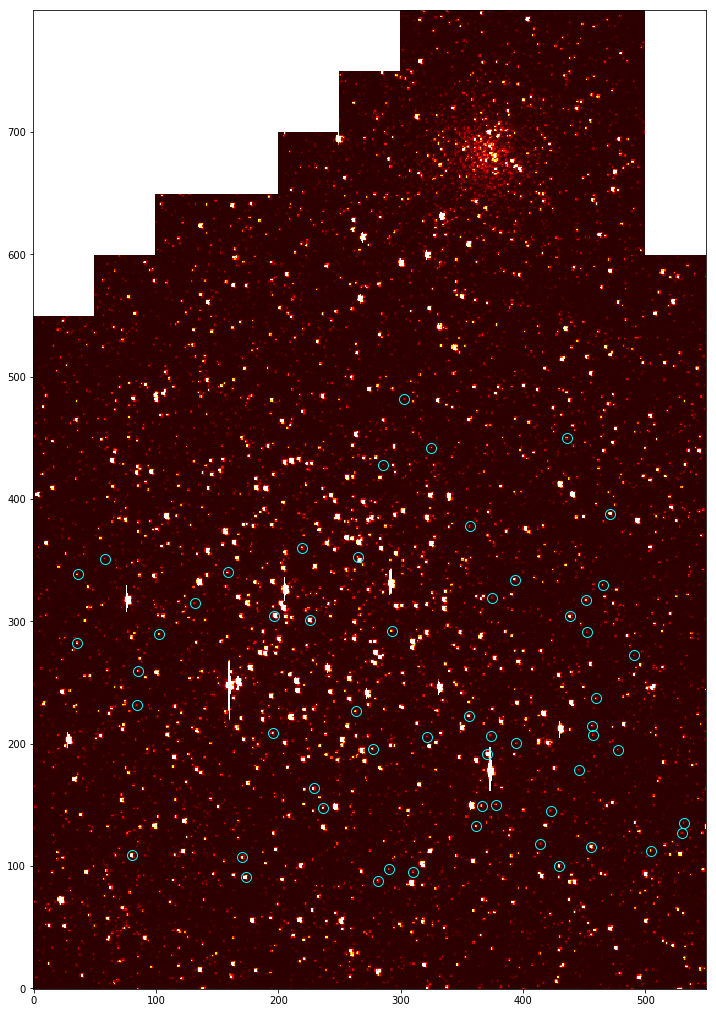

In [15]:
image = fits.getdata(filelist[0])
header = fits.getheader(filelist[0])
wcs_transform = wcs.WCS(header)
c = wcs_transform.wcs_world2pix(np.asarray([ra,dec]).T, 0)
plt.figure(figsize=(24, 18))
plt.imshow(image, cmap='hot', vmin = -100, vmax = 10000, interpolation='None', origin='lower')
plt.plot(c.T[0], c.T[1], marker="o", markersize = 10, markerfacecolor='None', markeredgecolor='cyan', linestyle='None')

#### The right ascension and declination of the star we are looking at 

In [16]:
star1ra = 92.126041
star1dec = 24.441154

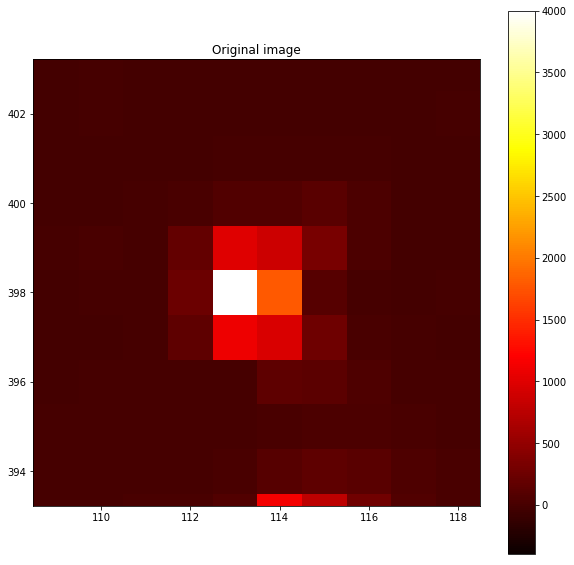

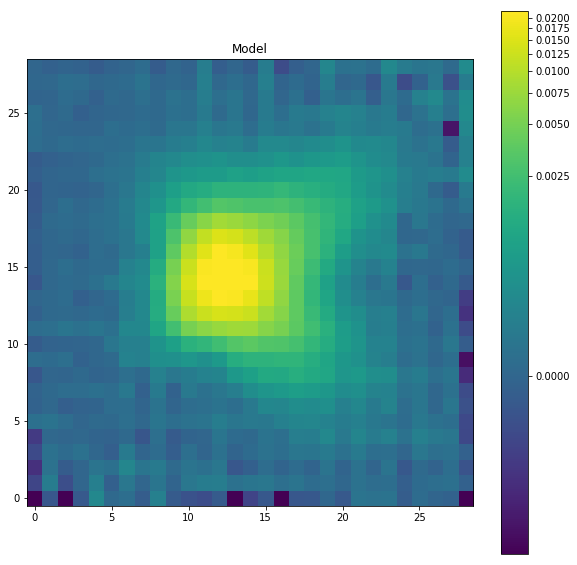

In [17]:
oversample = 4
header = fits.getheader(filelist[0])
data = fits.getdata(filelist[0])
wcs_transform = wcs.WCS(header)
xstar1, ystar1 = wcs_transform.wcs_world2pix([[star1ra, star1dec]], 0)[0]
coords = wcs_transform.wcs_world2pix(np.asarray([ra,dec]).T, 0)
stars_tbl = Table()
stars_tbl['x'] = coords.T[0]
stars_tbl['y'] = coords.T[1]
    
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = 2.)
data -= median_val
nddata = NDData(data = data)
stars = extract_stars(nddata, stars_tbl, size = 7)
epsf_builder = EPSFBuilder(oversampling =oversample, recentering_boxsize = 1, recentering_maxiters = 1,maxiters =10, progress_bar = False)
epsf, fitted_stars = epsf_builder(stars)
 
    #plot the original image
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='hot', vmin = -400, vmax = 4000, interpolation='None', origin='lower')
plt.xlim(xstar1 - 5, xstar1+5)
plt.ylim(ystar1 - 5,ystar1+5)
plt.colorbar()
plt.title('Original image')

norm = simple_norm(epsf.data, 'log', percent = 99.)
    
    #plot the models
plt.figure(figsize=(10, 10))
plt.imshow(epsf.data, norm = norm, origin = 'lower', cmap = 'viridis')
plt.colorbar()
plt.title('Model')
    
bkgrms = MADStdBackgroundRMS()
std = bkgrms(data)
daogroup = DAOGroup(2.0*0.5*gaussian_sigma_to_fwhm)
    
epsf.normalization_correction = 1.0/(oversample**2)
    
psf_model = epsf
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()



#### Loop through the three images and perform photometry

In [20]:
times = np.array([])
fluxes= np.array([])
aperture_fluxes = np.array([])
residual_fluxes = np.array([])
uncertainties = np.array([])

for x in np.arange(199):
    start = time.time()
    file = filelist[x]
    data = fits.getdata(file)
    header = fits.getheader(file)
    times = np.append(times, header['MIDTIME']) 
    wcs_transform = wcs.WCS(header)
    xstar1, ystar1 = wcs_transform.wcs_world2pix([[star1ra, star1dec]], 0)[0]
    posStar1 = Table(names = ['x_0', 'y_0'], data = [[xstar1], [ystar1]])       
       
    epsf.x_0.fixed = False
    epsf.y_0.fixed = False
    
    photometry = BasicPSFPhotometry(group_maker = daogroup, bkg_estimator = mmm_bkg, psf_model = psf_model, 
                               fitter = fitter, fitshape = (7, 7), aperture_radius = 3)
    result_tab_star1 = photometry(image = data, init_guesses = posStar1)
    residual_image_star1 = photometry.get_residual_image()
    fluxes = np.append(fluxes, result_tab_star1['flux_fit'])
    uncertainties = np.append(uncertainties, result_tab_star1['flux_unc'])
 
    #perform aperture photometry on the residuals to account for what the model missed
    position = [( result_tab_star1['x_fit']), ( result_tab_star1['y_fit'])]
    aperture = CircularAperture(position, r = 3.)
    phot_table = aperture_photometry(data, aperture)
    aperture_fluxes = np.append(aperture_fluxes, phot_table['aperture_sum'])
    residual_phot_table = aperture_photometry(residual_image_star1, aperture)
    residual_fluxes = np.append(residual_fluxes, residual_phot_table['aperture_sum'])
     
    '''#plot the residual images
    plt.figure(figsize=(10, 10))
    plt.imshow(residual_image_star1, cmap='hot', vmin = -400, vmax = 400, interpolation='None', origin='lower')
    plt.xlim(xstar1 - 5, xstar1+5)
    plt.ylim(ystar1 - 5,ystar1+5)
    plt.colorbar()'''
    '''plt.savefig('ResidualPlotsOneModel/' + str(x))'''
    
    #see how long each iteration takes
    end = time.time()
    print(x)
    #print(end - start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198


## Now explore the outputs

#### PSF fluxes and uncertainties

In [21]:
fluxes

array([14539.36746189, 14614.78859857, 14900.82801699, 15074.6977082 ,
       15087.59802422, 15124.30730605, 13750.13582676, 14884.7575922 ,
       14931.22713574, 14995.50415191, 14940.37699941, 14683.43171958,
       14861.56994791, 14853.0125443 , 14723.75464203, 14737.8959834 ,
       14827.53499983, 14689.6379595 , 14635.30539159, 14647.93881769,
       14255.12988003, 14503.91577282, 14447.76341067, 14361.40843414,
       14460.14905267, 14248.13274312, 14377.97135119, 14137.58447071,
       14152.30976812, 14422.33263499, 13282.66706131, 14495.21298368,
       14468.36435978, 14413.7230141 , 14570.20773611, 14368.68870708,
       14523.21184452, 14638.0436718 , 14458.11041303, 14698.19426461,
       14717.13406223, 14810.2215962 , 14729.30681135, 14751.41834189,
       14744.76227176, 14601.88046099, 14524.8075298 , 14547.26272719,
       14513.49877514, 14480.1744572 , 14499.09892913, 14386.84117894,
       14443.60300827, 14381.01042248, 14219.98583555, 14779.28336474,
      

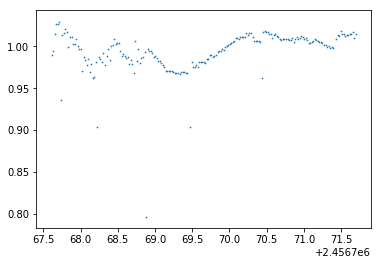

In [22]:
plt.scatter(times, fluxes/np.median(fluxes), s = 0.5)

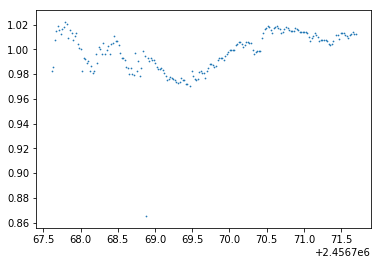

In [23]:
plt.scatter(times, (fluxes + residual_fluxes)/np.median(fluxes+residual_fluxes), s= 0.5)

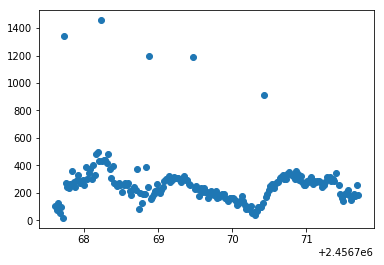

In [24]:
plt.scatter(times, residual_fluxes)

In [25]:
uncertainties

array([ 79.63515664,  83.19346159,  76.1228485 ,  77.18793   ,
        67.1928953 ,  73.80278499, 273.29222499,  66.07620877,
        66.14585954,  64.56774104,  70.39940227,  66.96721875,
        63.70356742,  67.4029787 ,  69.64090659,  67.06670587,
        62.44844979,  62.39810982,  64.1855648 ,  63.28067298,
        81.34110016,  68.65517067,  74.38497591,  78.04562331,
        74.87354084,  81.78278751,  83.15543703,  85.61326316,
        86.28159379,  60.89591331, 277.18609238,  65.28194899,
        73.41448182,  68.28145572,  72.18024034,  78.28597702,
        73.26395779,  70.01878727,  77.14715939,  69.08633171,
        70.71827776,  67.8805426 ,  69.47769692,  68.45531353,
        67.18748215,  70.99134452,  71.55954458,  72.46256658,
        72.28583644,  74.24208652,  73.77869571,  72.30543006,
        73.20252044,  74.7916595 ,  80.91485375,  67.98577801,
        74.61619395,  68.7914984 ,  77.47165796,  76.28091991,
        71.71657571,  62.92851743, 392.11825107,  67.56

#### Residual fluxes within a three pixel aperture

In [26]:
residual_fluxes

array([ 105.83184294,   72.71869943,  121.92983227,   55.61070942,
         93.14238915,   16.46041307, 1339.82289617,  269.67897128,
        239.90302458,  235.45559342,  265.43159526,  359.10046889,
        276.01986083,  243.41347767,  293.26612318,  327.78625592,
        270.89078379,  283.35534544,  290.54655281,  256.94389836,
        390.33475957,  299.91944861,  344.9987902 ,  376.45730729,
        302.2836571 ,  401.20303735,  330.84852136,  479.17587545,
        495.99251147,  431.70508757, 1457.05476018,  433.56072979,
        435.11611327,  435.09047137,  413.64228053,  481.94969161,
        373.27691448,  310.29528955,  392.01943297,  274.02574541,
        265.28810731,  250.08806163,  270.69258387,  253.07186621,
        207.61182753,  257.64816776,  272.76486715,  256.76215722,
        267.29481813,  211.93166845,  185.49359765,  226.45590583,
        240.82354813,  222.06373577,  376.38598213,   79.67967255,
        198.16670866,  127.40479162,  188.29865284,  192.52817

#### Aperture fluxes using a three pixel aperture

In [27]:
aperture_fluxes

array([26721.20716279, 26689.68242425, 26750.54877758, 26748.24905305,
       26785.55811703, 26756.3935904 , 26729.73769722, 26725.16250353,
       26746.20992941, 26789.67320837, 26817.43691944, 26853.34707873,
       26854.64505121, 26826.76945186, 26840.95668172, 26901.24111478,
       26907.65020388, 26920.03229905, 26909.44520919, 26883.45608028,
       26870.95344738, 26903.01650721, 26926.59526263, 26942.2776911 ,
       26929.18984017, 26907.95803315, 26894.27605359, 26918.29925067,
       26933.26674089, 26933.26514175, 26919.80932078, 26938.69319485,
       26946.76563006, 26945.37116203, 26999.25860615, 27029.3326036 ,
       27022.06175358, 27033.89834332, 26997.94304962, 27006.59523561,
       27054.77393429, 27071.62057163, 27091.19103062, 27083.60320462,
       27053.83632224, 27062.19661903, 27099.26585357, 27128.33004236,
       27099.08500295, 27100.1235573 , 27055.25803752, 27021.54826692,
       27060.47059233, 27069.16054634, 27088.70020937, 27033.00961886,
      

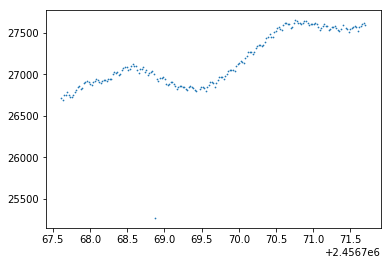

In [28]:
plt.scatter(times, aperture_fluxes, s = 0.5)